# **<p style="font-family:newtimeroman;font-size:200%;text-align:center;color:#3B3B3B;">Spam Detection through NLP: Evaluating Multiple Classification Models</p>**

In [1]:
# Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [2]:
spam = pd.read_csv("spam.csv")
spam.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [3]:
# 5572 rows and 2 columns
spam.shape

(5572, 2)

In [4]:
spam.isnull().sum()

Category    0
Message     0
dtype: int64

In [5]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


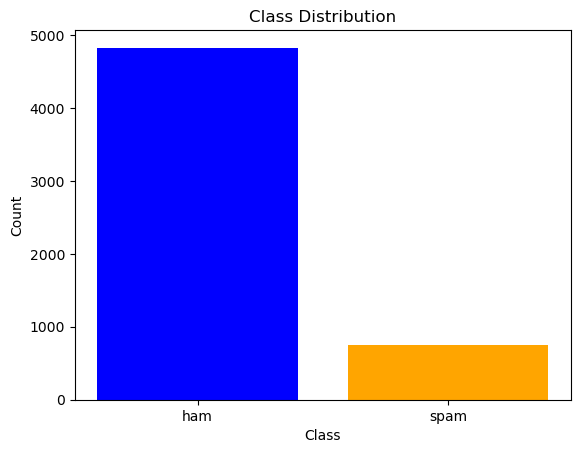

ham     86.593683
spam    13.406317
Name: Category, dtype: float64


In [6]:
target_counts = spam['Category'].value_counts()

plt.bar(target_counts.index, target_counts.values,color=['b','orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

class_percentages = target_counts / len(spam) * 100
print(class_percentages)

In [7]:
spam.duplicated().any()

True

In [8]:
spam[spam.duplicated()]

,Category,Message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [9]:
spam.drop_duplicates(inplace=True)

In [10]:
spam.duplicated().any()

False

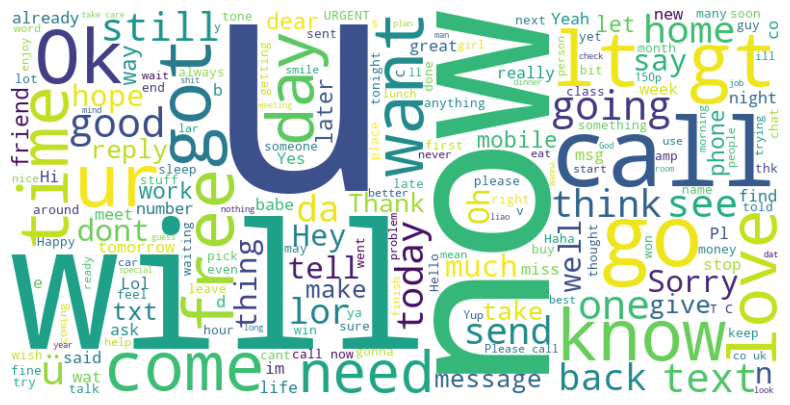

In [11]:
# Visualizing the messages
all_text = " ".join(spam['Message'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Top 20 Most Common Words

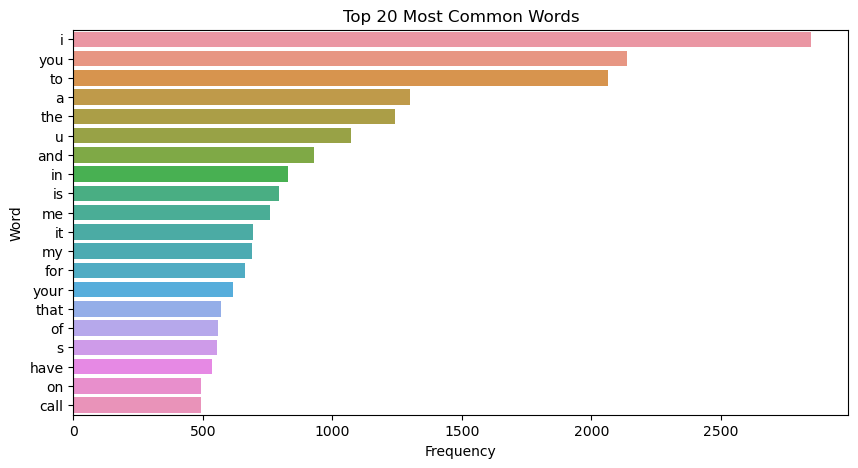

In [12]:
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)

word_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])


plt.figure(figsize=(10, 5))
sns.barplot(x='Frequency', y='Word', data=word_df)
plt.title("Top 20 Most Common Words")
plt.show()

## Encoding Categorical Data Using Label Encoder

In [13]:
# Since the order of the spam and is important, Label Encoder is used
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
spam['Category'] = le.fit_transform(spam['Category'])

In [14]:
# ham = 0 , spam = 1
spam.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Cleaning the Texts

In [15]:
# Necessary Libraries
import emoji
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

In [16]:
# Checking if there are emojis
import emoji

def contains_emoji(text):
    return emoji.emoji_count(text) > 0

emoji_rows = spam[spam['Message'].apply(contains_emoji)]
print(emoji_rows)
# there are no emojis in df

Empty DataFrame
Columns: [Category, Message]
Index: []


In [17]:
# Downloading stopwords and cleaning the texts
nltk.download('stopwords')
nltk.download('punkt')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
stop_words.discard('not')  # Keep 'not' for handling negations

# Define chat words dictionary for handling abbreviations
chat_words_dict = {
    "u": "you",
    "ur": "your",
    "y": "why",
    "b4": "before",
    "gr8": "great",
    "l8r": "later",
    "lol": "laughing out loud",
    "lmao": "laughing my ass out",
    "ilu": "i love you",
    "bae": "before anything else",
    "FAQ": "Frequently Asked Questions"
}


def expand_chat_words(text, chat_words_dict):
    tokens = nltk.word_tokenize(text)
    expanded_text = [chat_words_dict.get(word, word) for word in tokens]
    return ' '.join(expanded_text)

def preprocess_text(text):
    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Lowercase
    text = text.lower()

    # 4. Remove punctuations and special characters, retain only letters and single spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 5. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Expand chat words
    text = expand_chat_words(text, chat_words_dict)

    # 7. Tokenize and remove stop words and numbers
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words and not word.isnumeric()]

    # 8. Join words to form the cleaned text
    processed_text = ' '.join(words)

    # 9. Convert emojis to descriptive text (optional)
    # Since there are no emojis in the dataset
    # processed_text = emoji.demojize(processed_text, delimiters=(":", ":"))

    return processed_text

# Process the entire spam
corpus = []
for index, row in spam.iterrows():
    if pd.notna(row['Message']):  # Check if 'Message' is not NaN
        processed_review = preprocess_text(row['Message'])
        corpus.append(processed_review)


[nltk_data] Downloading package stopwords to C:\Users\ADMIN
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ADMIN
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [18]:
print(corpus)

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat', 'ok lar joke wif oni', 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli', 'dun say earli hor c alreadi say', 'nah think goe usf live around though', 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv', 'even brother not like speak treat like aid patent', 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun', 'winner valu network custom select receivea prize reward claim call claim code kl valid hour', 'mobil month r entitl updat latest colour mobil camera free call mobil updat co free', 'gon na home soon want talk stuff anymor tonight k cri enough today', 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info', 'urgent week free membership prize jackpot txt word claim c lccltd pobox ldnw rw', 'search right word thank breather promis wont take help grant 

## Creating the Bag of Words model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert corpus into features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)  # Vectorize the preprocessed text data
y = spam['Category']  # Target labels

# Check shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (5157, 6248)
Shape of y: (5157,)


## Splitting the dataset into the Training set and Test set

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## The Models

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the classifiers
models = {
    "MultinomialNB": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

# Store results
results = []
classification_reports = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({"Model": model_name, "Accuracy": accuracy})
    
    report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"], output_dict=True)
    classification_reports[model_name] = report


results_df = pd.DataFrame(results)

print(results_df)

for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n")
    print(pd.DataFrame(report).transpose())

                 Model  Accuracy
0        MultinomialNB  0.964147
1  Logistic Regression  0.980620
2                  SVM  0.978682

Classification Report for MultinomialNB:

              precision    recall  f1-score      support
Ham            0.991982  0.966518  0.979084   896.000000
Spam           0.811321  0.948529  0.874576   136.000000
accuracy       0.964147  0.964147  0.964147     0.964147
macro avg      0.901651  0.957524  0.926830  1032.000000
weighted avg   0.968174  0.964147  0.965312  1032.000000

Classification Report for Logistic Regression:

              precision    recall  f1-score     support
Ham            0.981319  0.996652  0.988926   896.00000
Spam           0.975410  0.875000  0.922481   136.00000
accuracy       0.980620  0.980620  0.980620     0.98062
macro avg      0.978364  0.935826  0.955703  1032.00000
weighted avg   0.980540  0.980620  0.980169  1032.00000

Classification Report for SVM:

              precision    recall  f1-score      support
Ham     

## Testing On A Message

In [22]:
# Sample message for testing
test_message = "You've been selected to receive a $1,000 Walmart gift card! Click here to claim your prize!"
processed_message = preprocess_text(test_message)
message_vectorized = vectorizer.transform([processed_message])

predictions = {}
for model_name, model in models.items():
    pred = model.predict(message_vectorized)
    predictions[model_name] = "Spam" if pred[0] == 1 else "Ham"


print("Predictions for the test message:")
for model_name, prediction in predictions.items():
    print(f"{model_name}: {prediction}")

Predictions for the test message:
MultinomialNB: Spam
Logistic Regression: Spam
SVM: Spam
